In [44]:
import mlflow
import mlflow.lightgbm
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, title2filename

## MLflow 설정

In [45]:
os.environ["LOGNAME"] = "lnh"
remote_server_uri="http://118.67.134.110:30005"
mlflow.set_tracking_uri(remote_server_uri)

client = mlflow.tracking.MlflowClient()
experiment_name = "lgbm_parameter_opt"

try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
experiment_id

'166033867377195502'

## 데이터 불러오기 및 split

In [46]:
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 87), (1974, 87), (260114, 87))

((1845539, 86), (1845539, 1), (1974, 86), (1974, 1))

## optuna
### 하이퍼 파라미터
- optuna.trial.Trial.suggest_categorical() : 리스트 범위 내에서 값을 선택한다.
- optuna.trial.Trial.suggest_int() : 범위 내에서 정수형 값을 선택한다.</br>
"reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
- optuna.trial.Trial.suggest_float() : 범위 내에서 소수형 값을 선택한다.</br>
"max_depth": trial.suggest_int("max_depth", 1, 20),
- optuna.trial.Trial.suggest_uniform() : 범위 내에서 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_discrete_uniform() : 범위 내에서 이산 균일분포 값을 선택한다.
- optuna.trial.Trial.suggest_loguniform() : 범위 내에서 로그 함수 값을 선택한다.


In [47]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [48]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

def objective(trial: Trial) -> float:
    # Hyper parameter 설정
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 80, 13000),
        "max_depth": trial.suggest_int("max_depth", 5, 10000000),  # 8,
        "num_leaves": trial.suggest_int("num_leaves", 25, 40),
    #     "min_data_in_leaf": 1000,
        # "feature_fraction": 0.6,  # 0.8,
    #     "bagging_fraction": 0.75,
        # "max_cat_group": 64,
        "objective": "binary",
    #     "boosting": "gbdt",  # dart
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05), #0.023
        # "bagging_freq": 5,
        "seed": 42,
        # "max_bin": 50,
    #     "num_leaves": 80,  # 40,
    #     "metric": "auc",
        "colsample_bytree":trial.suggest_float("colsample_bytree", 0.5, 1),
    }
    ### 피처 설정
    # 사용할 Feature 설정
    FEATS = ['uidIdx',
             'assIdx',
             'testIdx',
             'KnowledgeTag',
             'user_correct_answer',
             'user_total_answer',
             'big_category',
             'mid_category',
             'problem_num',
             'month','day','dayname','hour',
             'test_mean',
             'test_sum',
             'test_std',
             'tag_std',
             'tag_mean',
             'tag_sum',
             'solvesec_3600',
             'time_category',
             'solvesec_cumsum',
             'solvecumsum_category',
             'big_category_cumconut',
             'big_category_user_cum_acc',
             'mid_category_cumconut',
             'mid_category_user_cum_acc',
             'assess_count',
             'elo_assessmentItemID',
             'elo_problem_num',
            ]

    cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
                 'problem_num','dayname','month','time_category','solvecumsum_category']
    cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

    ### 학습 및 예측

    date = datetime.now().strftime('%m/%d %a')
    title=f"🌈({date})[LGBM] optuna"
    using_feats=", ".join(FEATS)
    desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
    cat_feats_idx, title, desc

    mlflow.lightgbm.autolog()
    lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
    lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

    model = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    # mlflow.log_metric("VAL AUC",auc)
    # mlflow.log_metric("VAL Set SEED",SEED)
    # model_run_id=run.info.run_id
    # post_slack("done")
    # print(f"{model_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model, FEATS, f'{file_name}.csv')

    q = pd.Series(test_preds).plot(kind='kde')
    return auc

In [ ]:
from optuna.integration.mlflow import MLflowCallback
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

print("Optimize a model...")


remote_server_uri="http://118.67.134.110:30005"
def make_mlflow_callback():
    cb = MLflowCallback(
         tracking_uri = mlflow.get_tracking_uri(),
         metric_name="VAL AUC",
         create_experiment=True)
    return cb

mlflow_cb = make_mlflow_callback()

study.optimize(
    objective, n_trials = 50, callbacks=[mlflow_cb], show_progress_bar=True
)

[I 2022-12-08 04:34:35,448] A new study created in memory with name: lgbm_parameter_opt


Optimize a model...


  0%|          | 0/50 [00:00<?, ?it/s]

2022/12/08 04:34:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '960e3f76cd384c449a3c39a7096b9e4e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19966
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.527481


In [ ]:
!pwd

<!-- 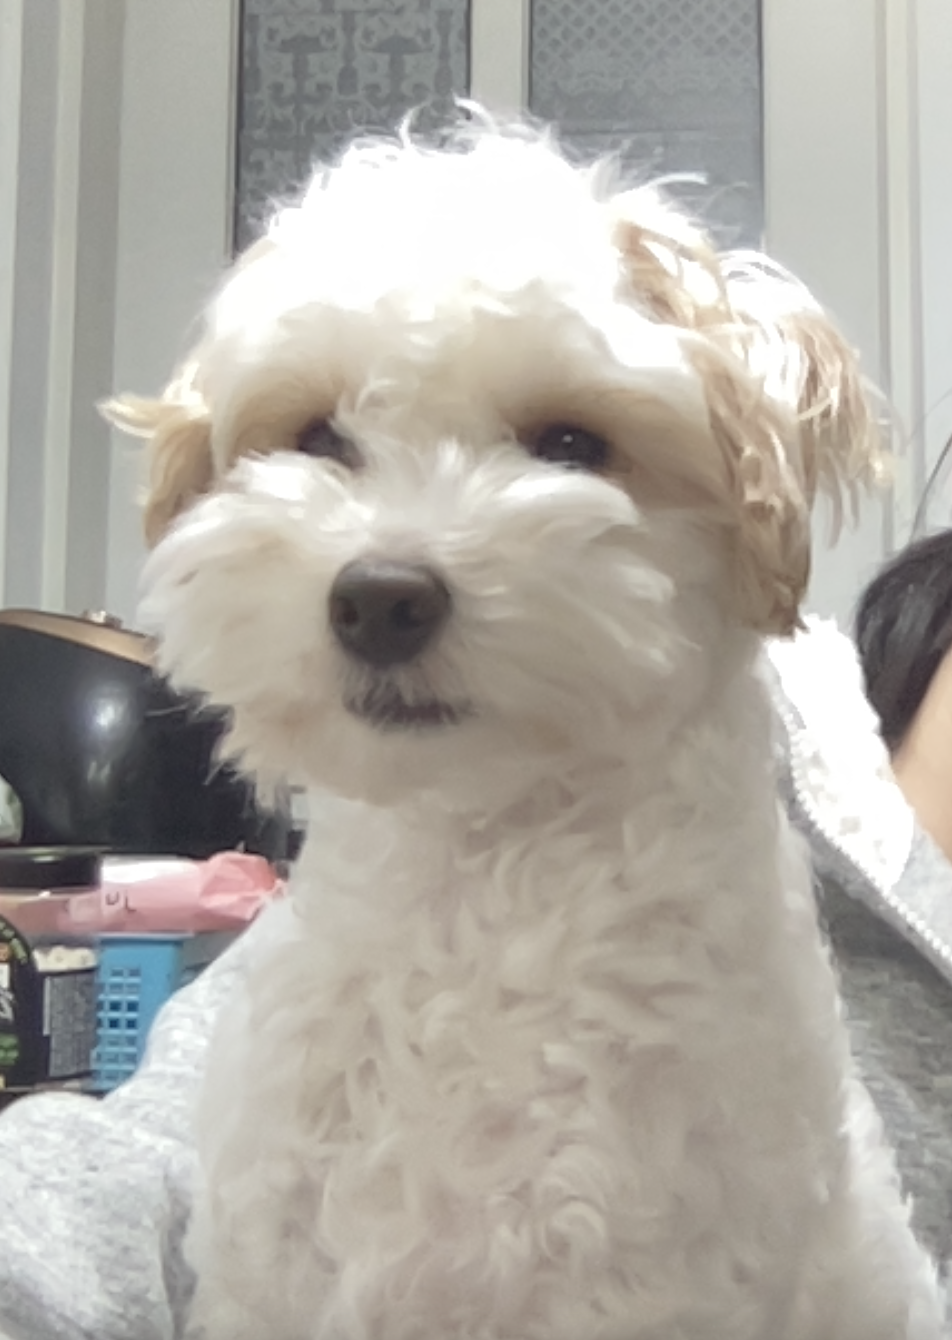 -->
<!-- <img alt="img" src=image_plot> -->

In [18]:
import io
from PIL import Image

In [42]:
# optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프
# optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화
fig = optuna.visualization.plot_parallel_coordinate(study)
# # fig.show()

In [42]:
# image_plot = fig.to_image('png')
# # image_plot_io = Image.open(image_plot)
# # img = Image.open(image_plot)
# # image_plot.show()

[W 2022-12-08 04:09:55,212] Your study does not have any completed trials.


In [ ]:
# optuna.visualization.plot_intermediate_values(study).show(renderer="browser")

Writing default config to: /opt/ml/.jupyter/jupyter_notebook_config.py
